In [1]:
import eli5
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_accuracy_score

from crf_extraction.first_crf_model.first_model_features import sent_to_features, sent_to_labels
from utils.DrugRecords import DrugRecords
from utils.helper_functions import get_data

In [2]:
from utils.helper_functions import generate_heatmap_percentage, generate_heatmap_values
TRAINING_DATASET_PATH = "../../datasets/train_dataset.csv"
VALIDATION_DATASET_PATH = "../../datasets/validation_dataset.csv"
TEST_DATASET_PATH = "../../datasets/test_dataset.csv"
JOBLIB_NAME_PATH = 'trained.joblib'

In [3]:
training_data = get_data(TRAINING_DATASET_PATH)
training_data.head(10)

,Drug: #,Word,Tag
0,Drug: #,Word,Tag
1,Drug: 0,ventamol,NAME
2,Drug: 0,2,STRENGTH
3,Drug: 0,mg,STRENGTH
4,Drug: 0,/,STRENGTH
5,Drug: 0,5,STRENGTH
6,Drug: 0,ml,STRENGTH
7,Drug: 0,syrup,FORM
8,Drug: 0,120,PACK
9,Drug: 0,ml,PACK


In [4]:
train_drug_records = DrugRecords(training_data).get_drug_records()
train_drug_records = train_drug_records[1:] # without header

In [5]:
x_train = [sent_to_features(s) for s in train_drug_records]
y_train = [sent_to_labels(s) for s in train_drug_records]

In [6]:
x_train[0][0] # features for word "ventamol"

{'bias': 1.0,
 'word[-2:]': 'ol',
 'word[:-3]': 'venta',
 'word.isdigit()': False,
 'BOS': True,
 '+1:bias': 1.0,
 '+1:word[-2:]': '2',
 '+1:word[:-3]': '',
 '+1:word.isdigit()': True}

Fit and save the model

In [7]:
crf = CRF(c1=0, c2=1, max_iterations=1, all_possible_transitions=False)
crf.get_params()

{'algorithm': None,
 'all_possible_states': None,
 'all_possible_transitions': False,
 'averaging': None,
 'c': None,
 'c1': 0,
 'c2': 1,
 'calibration_candidates': None,
 'calibration_eta': None,
 'calibration_max_trials': None,
 'calibration_rate': None,
 'calibration_samples': None,
 'delta': None,
 'epsilon': None,
 'error_sensitive': None,
 'gamma': None,
 'keep_tempfiles': None,
 'linesearch': None,
 'max_iterations': 1,
 'max_linesearch': None,
 'min_freq': None,
 'model_filename': None,
 'num_memories': None,
 'pa_type': None,
 'period': None,
 'trainer_cls': None,
 'variance': None,
 'verbose': False}

In [8]:
%%time

crf.fit(x_train, y_train)
dump(crf, JOBLIB_NAME_PATH)

CPU times: user 10.3 s, sys: 104 ms, total: 10.4 s
Wall time: 10.4 s


['trained.joblib']

In [9]:
x_train = [sent_to_features(s) for s in train_drug_records]
y_train = [sent_to_labels(s) for s in train_drug_records]
y_pred = cross_val_predict(estimator=crf, X=x_train, y=y_train, cv=5)

In [10]:
class_report = flat_classification_report(y_pred=y_pred, y_true=y_train, digits=4)
print(class_report)

/home/michaela/PycharmProjects/master-thesis/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        FORM     0.0000    0.0000    0.0000    315394
        NAME     0.0000    0.0000    0.0000    200615
           O     0.0000    0.0000    0.0000     84099
        PACK     0.0000    0.0000    0.0000    309008
    STRENGTH     0.3270    1.0000    0.4928    441687

    accuracy                         0.3270   1350803
   macro avg     0.0654    0.2000    0.0986   1350803
weighted avg     0.1069    0.3270    0.1611   1350803



In [11]:
eli5.show_weights(crf, top=20)

Evaluate on validation data

In [12]:
validation_data = get_data(VALIDATION_DATASET_PATH)

validation_drug_records = DrugRecords(validation_data).get_drug_records()
validation_drug_records = validation_drug_records[1:]

In [13]:
x_val = [sent_to_features(s) for s in validation_drug_records]
y_val = [sent_to_labels(s) for s in validation_drug_records]

In [14]:
predicted_values = crf.predict(x_val)

In [15]:
acc_score = flat_accuracy_score(predicted_values, y_val)
print(acc_score)

0.32577679797013437


Evaluate on test data

In [16]:
test_data = get_data(TEST_DATASET_PATH)

test_drug_records = DrugRecords(test_data).get_drug_records()
test_drug_records = test_drug_records[1:]

In [17]:
x_test = [sent_to_features(s) for s in test_drug_records]
y_test = [sent_to_labels(s) for s in test_drug_records]

In [18]:
predicted_values = crf.predict(x_test)

In [19]:
acc_score = flat_accuracy_score(predicted_values, y_test)
print(acc_score)


0.32552038406396305


Cross matrices on test data

In [20]:
y_pred = pd.Series([p for pred_val in predicted_values for p in pred_val])
y_true = pd.Series([w[1] for drug_record in test_drug_records for w in drug_record])

matrixValues = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
matrixPercentage = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], normalize="index").round(6)*100

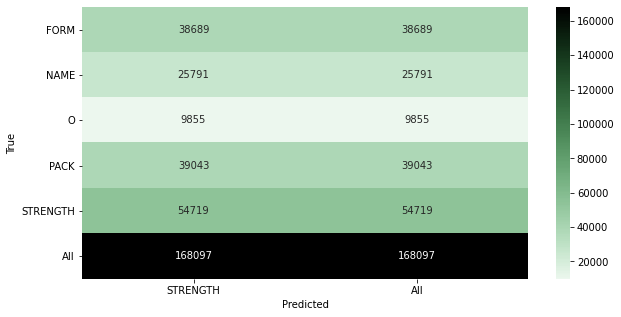

In [21]:
plt.figure(figsize=(10, 5))
sns_plot_values = generate_heatmap_values(matrixValues)

sns_plot_values.figure.savefig("firstCrfModelMatrixValues.png")

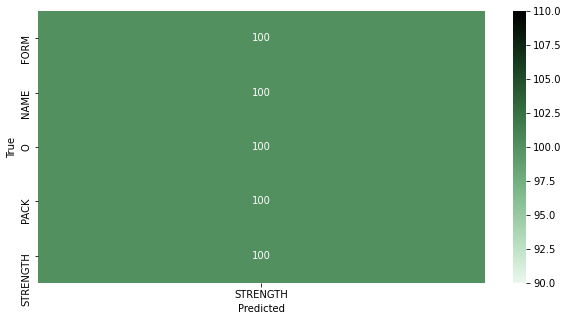

In [22]:
plt.figure(figsize=(10, 5))
sns_plot_percentage = generate_heatmap_percentage(matrixPercentage)

sns_plot_percentage.figure.savefig("firstCrfModelMatrixPercentage.png")
